In [1]:
# Unnecessary unless you are using a GPU by default
import os
os.environ['THEANO_FLAGS'] = 'device=cpu'

# Introduction

We've spent lots of time talking about sampling methods for approximating a posterior distribution. In this notebook, we'll use software packages built around this workflow for doing statistical inference. The wonderful thing about using Markov chain Monte Carlo is that we can fit an enormous range of different Bayesian models without using a different algorithm. We'll look at how to fit a linear regression model to a relatively simple dataset and also assess (1) how well the sampler worked, and (2) to what degree the model is a good fit to the data. Before this however, we will briefly discuss *probabilistic programming*.

# Probabilistic programming

The software package we'll be using, PyMC3, is an example of a probabilistic programming language. This isn't a programming language in the same way that you consider Python or Java to be a programming language that performs deterministic operations on some computer memory. Instead, it's a syntax for declaring probabilistic models in such a way that doing operations like estimating parameters or predicting on new data is especially easy. Every PPL usually includes some sort of automatic inference algorithm that works on a very broad class of problems.

Unless you are a statistician comfortable with implementing or inventing new model-fitting algorithms on your own, the alternative approach for computational statistics is to find a specific algorithm for every model you want to fit. This is common for many applications, but carries a number of disadvantages:
* You need to learn/download a new piece of software for every different model you want to run
* The specific package you have in mind may not fully fit the problem you have, leading to model misspecification
* For many cutting-edge applications, the software may not be well tested or documented and debugging it may be very difficult
* It is a large amount of work to optimize one-off methods to work with GPUs, in the cloud, and in high performance computing environments

A favorite analogy of mine is that learning to use a PPL is a bit like setting up a factory for statistical models - once you have it learned correctly, you can repeat the same kind of high-quality analysis in many different problems without having to worry about creating a new algorithm or estimation method every time. To give an example of how this works, I've borrowed a figure from one of our papers: 

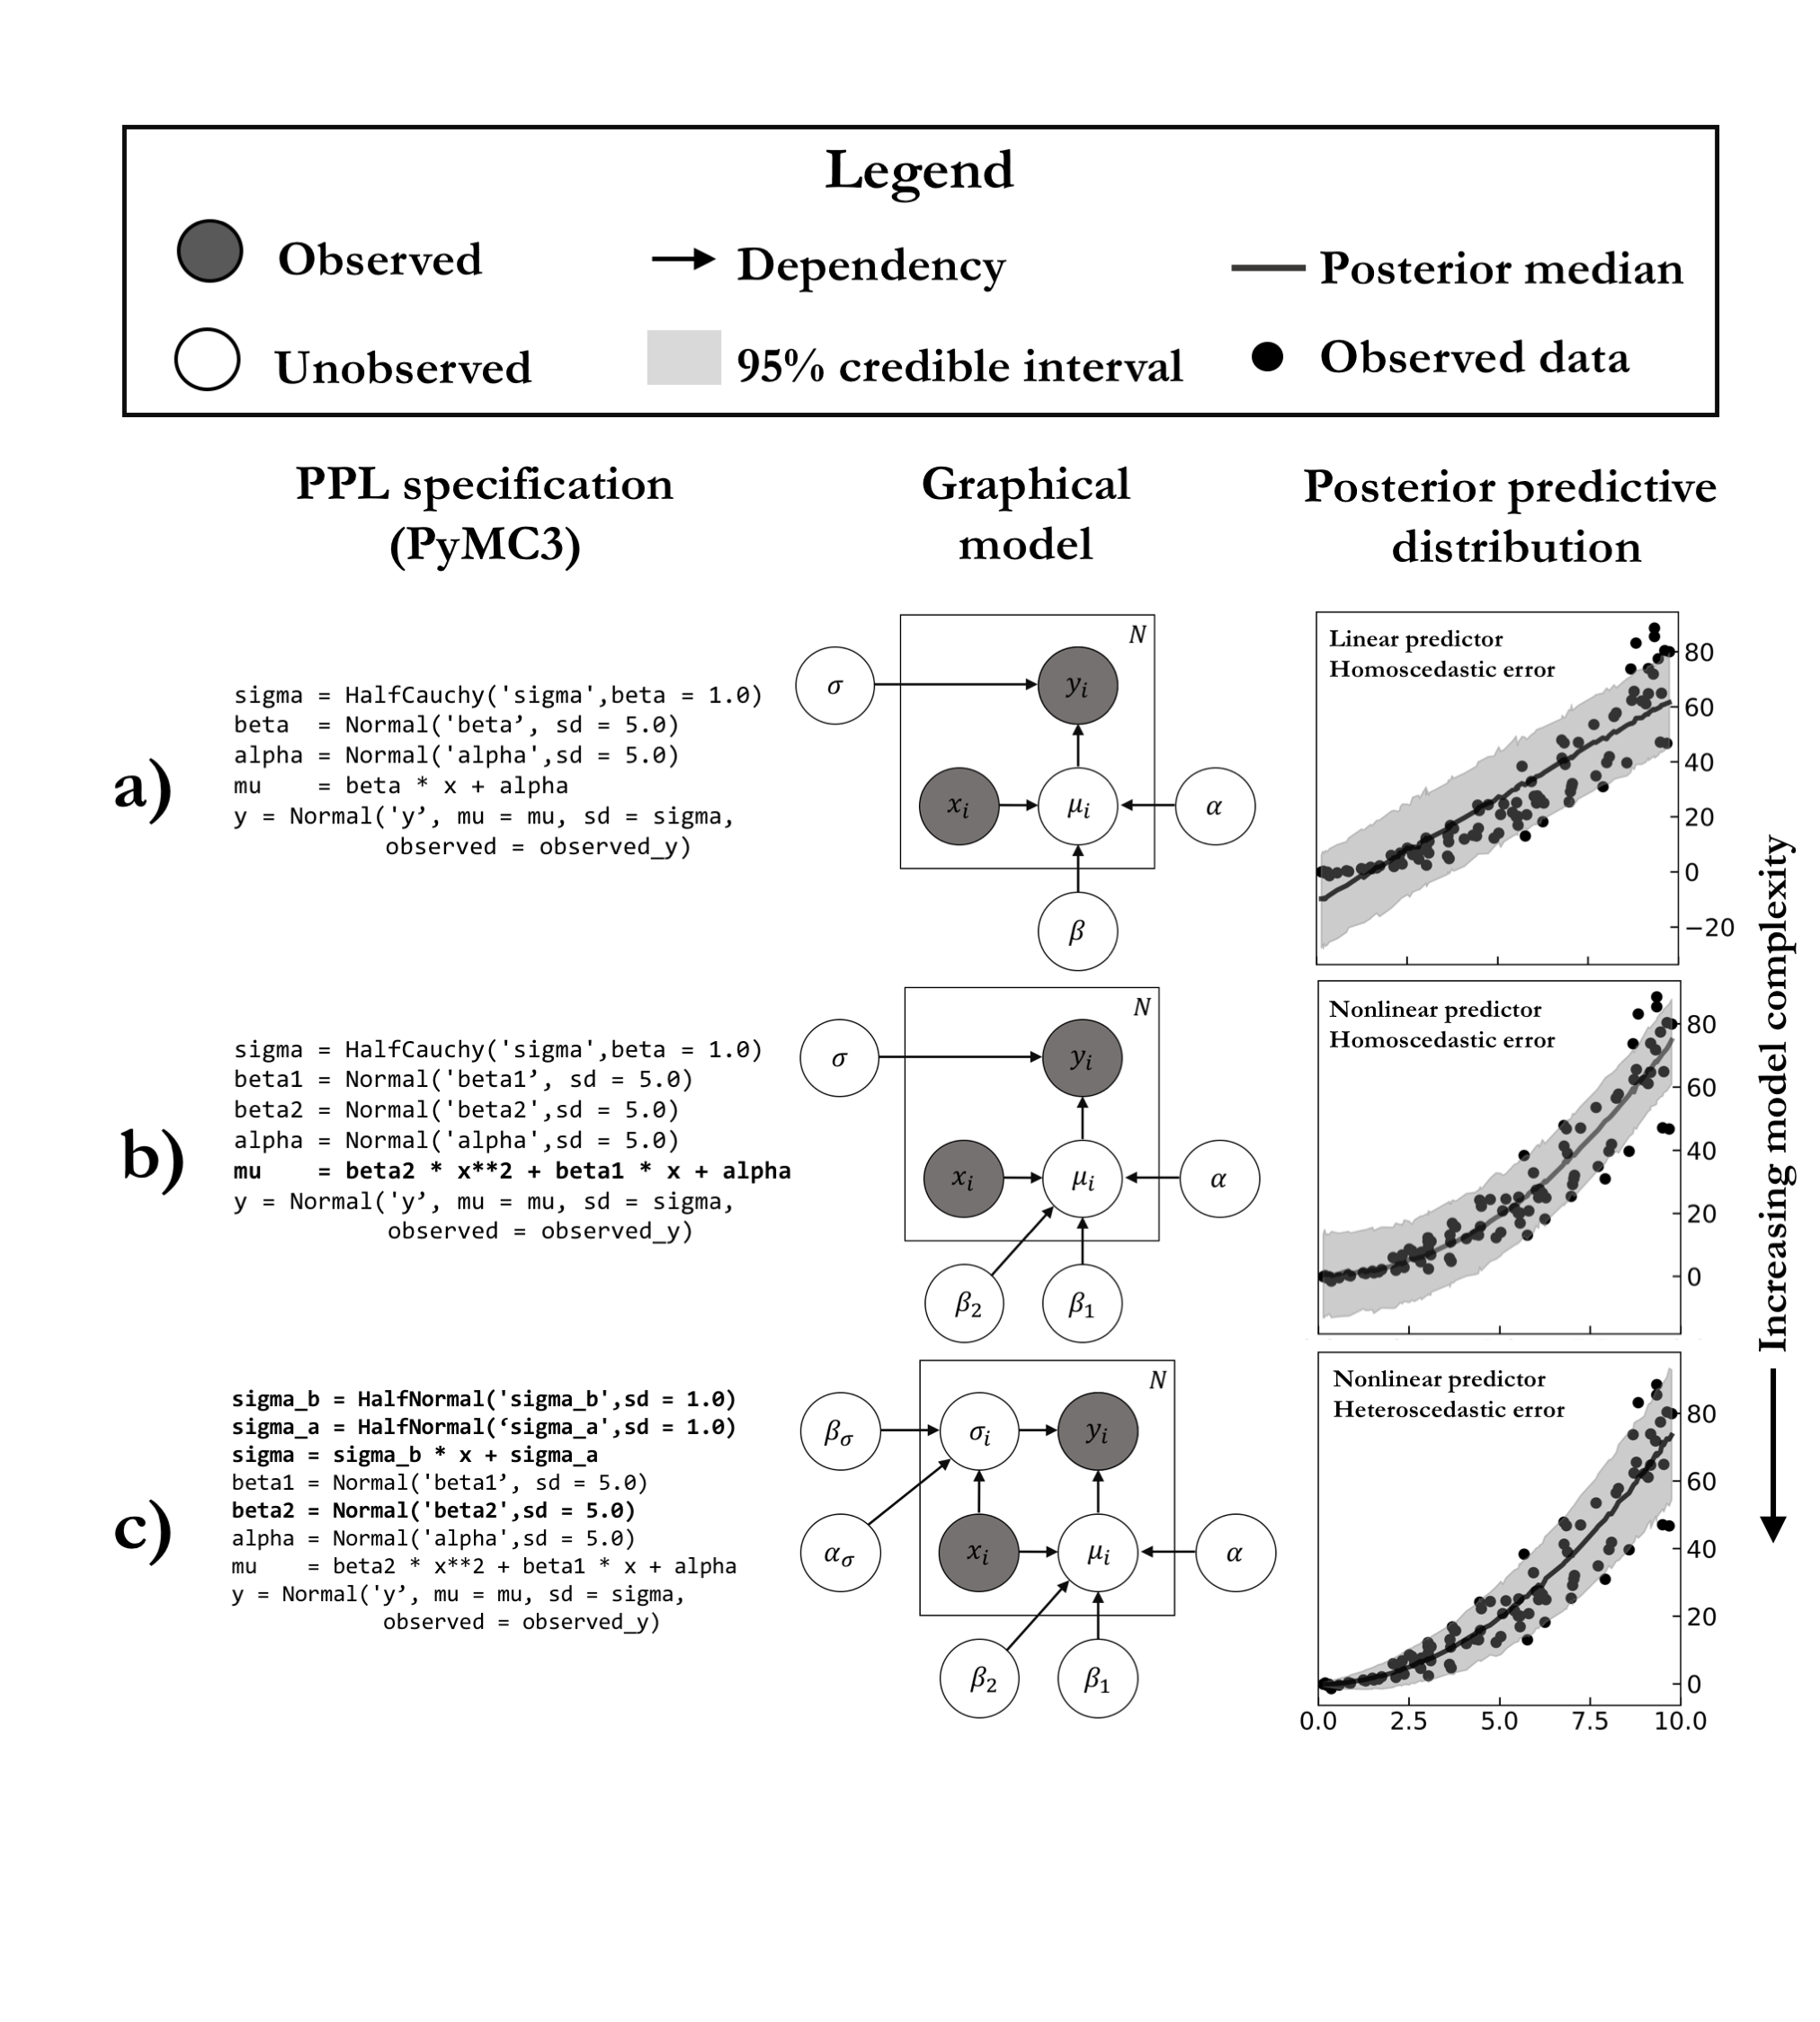

The gist of this figure is that if we find that our current model isn't as good as we'd like, we can keep adding or modifying random variables until it's right. This is quite easy in a PPL but very hard otherwise. Example of alternative PPLs include BUGS, Stan, Edward, Pyro, and JAGS.

# Data

We'll be using the Boston housing price dataset to explore some of the functionality of PyMC3. Install scikit-learn if you don't have it available already so that you can use it to import the dataset.

In [2]:
import pandas as pd
from sklearn.datasets import load_boston
boston = load_boston()
df     = pd.DataFrame(data=boston['data'],columns=boston['feature_names'])
df['MEDV'] = data=boston['target']
print(df.shape)
print(df.head())

(506, 14)
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


Let's take a look at the different columns in this dataset.

In [3]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

To start out, we'll work with a single predictor so we can see how simple linear regression works in PyMC3. We can use the number of rooms (`'RM'`) for this first model. In probabilistic terms, this means that the median value of a home (`MEDV`) is distributed according to:
$$MEDV \sim N(\beta \times RM,\sigma^2)$$

The way that we'll implement and fit a regression model in PyMC3 is by specifying a computation graph which links the likelihood, the posterior, and the observed data. When we run code saying to add a `Normal` distribution to the model, no numerical computations will be actually be done at that moment - all we are doing is telling the computer to add another term to the posterior. Then, the actual numerical computation will only be done once we actually tell PyMC3 to draw samples from the posterior.

As a final aside, while we are using PyMC3 which is one specific type of software for doing this type of modeling, there are many more PPLs which follow the same workflow but are optimized for neural networks, big data, or other special modeling challenges.

# Creating and adding variables to a PyMC3 model

The first step is to initialize a `Model` object. This object is going to receive all the metadata regarding the posterior density, where the observed data is, and all sorts of other info.

In [4]:
import pymc3 as pm
simple_model = pm.Model()

Next, we start adding random variables within the model.

In [5]:
with simple_model:
    intercept = pm.Normal('intercept',mu=0,sd=100)

Here, we are adding the first random variable which is going to be our regression intercept. Since we don't have a good idea of what the intercept might or should be, we will give it a very uninformative or weak prior with a standard devation of 100. Also, note that we could pass a different name rather than `'intercept'` to the constructor `Normal` but this will just change the name that PyMC3 uses to refer to this variable internally.

We can also do the same thing with our regression coefficient. If we omit the `mu` keyword argument, then it assumes a default of zero which is fine from our point of view. The documentation for different PyMC3 distributions can be viewed at https://docs.pymc.io/api/distributions.html.

In [6]:
with simple_model:
    beta = pm.Normal('beta',sd=100)

The next thing that we do might seem a little less familiar. We have to estimate the variance $\sigma^2$ from the data which means we need to put a prior distribution on it. We haven't discussed prior distributions for the variance but the standard Bayesian cookbook for modeling suggests that we do it one of two ways:
* We place an inverse-Gamma prior on $\sigma^2$ (This is actually a conjugate prior for the variance of a Normal distribution)
* We place a Half-Cauchy prior on the standard devation $\sigma$.
The Half-Cauchy distribution is just the Cauchy distribution centered at zero, but with a PDF of zero for any negative numbers. This is quite appropriate since the variance parameter $\sigma^2$ and equivalently the standard deviation $\sigma$ are by definition positive quantities. We certainly don't want a prior that places any probability mass on negative numbers.

Each of these priors will have its own hyperparameters; for the Inverse-Gamma distribution, a setting of $\alpha=1/10$, $\beta=1/10$ is mostly uninformative. We then convert the variance into a standard devation by taking its square root.

In [7]:
with simple_model:
    variance = pm.InverseGamma('variance',alpha=0.1,beta=0.1)
    sd       = pm.Deterministic('sd',variance**0.5)

An interesting thing about this code cell is that we used the built-in Python operator `**` to represent exponentation (to the 1/2 power) and PyMC3 handles this appropriately. Remember, the value `variance**0.5` is *not* being computed when the above cell is run - all we are doing is telling PyMC3 to add a random variable to the model graph which is a deterministic transformation of `variance`.

You may remember that the density of a transformed random variable must take into account the Jacobian of that transformation. PyMC3 takes care of this for us and we don't have to do a thing!

The final ingredient of this model is specifying the likelihood. To specify that we have observed data, we just pass the data to a distribution using the `observed` keyword argument

In [8]:
with simple_model:
    yhat = intercept + beta*df['RM']
    y    = pm.Normal('y', mu=yhat, sd=sd, observed=df['MEDV'])

Now that the model is defined, we can inspect some of its properties.

In [9]:
simple_model.vars

[intercept, beta, variance_log__]

Here, the `variance` parameter has had `log` added onto it. This is because PyMC3 prefers to do parameter sampling in a space in which there are no boundaries or constraints. Since our variance parameter is restricted to be positive, PyMC3 automatically decides to work with the log of the variance which can take values over all the real numbers.

In [10]:
simple_model.observed_RVs

[y]

In [11]:
simple_model.unobserved_RVs

[intercept, beta, variance_log__, variance, sd]

In [12]:
simple_model.test_point

{'intercept': array(0., dtype=float32),
 'beta': array(0., dtype=float32),
 'variance_log__': array(-2.3978953, dtype=float32)}

In [13]:
simple_model.logp(simple_model.test_point)

array(-1647817.58266941)

In [14]:
simple_model.logp({'intercept':2.0,'beta':0.5,'variance_log__':1.0})

array(-36331.08113257)

## In-class exercise:

Rewrite the above model but instead using a Half-Cauchy prior with $\beta=1$ on the `sd` parameter.

# Sampling the posterior

Once the model is defined, we can start using Markov chain Monte Carlo to draw samples from the posterior. PyMC3 has multiple algorithms built in; its default is a more advanced method called the No-U-Turn sampler which is itself a variety of Hamiltonian Monte Carlo which we will discuss later in the course. However, we can also use the Metropolis algorithm too. Within the parlance of PyMC3, these are referred to as stepping methods since each one applies multiple steps of MCMC.

In [15]:
with simple_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance, beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 500.93draws/s]
The acceptance probability does not match the target. It is 0.8951528572242174, but should be close to 0.8. Try to increase the number of tuning steps.


The trace object is structured like a dict. You can access sample values using string names of variables.

In [16]:
trace['beta'].shape

(1000,)

We can make plots of the samples manually but PyMC3 has functionality for this already built in. 

(array([ 17.,  56., 145., 241., 219., 185.,  98.,  25.,   8.,   6.]),
 array([ 8.081968 ,  8.324062 ,  8.566157 ,  8.808252 ,  9.050346 ,
         9.29244  ,  9.534535 ,  9.77663  , 10.018724 , 10.2608185,
        10.502913 ], dtype=float32),
 <a list of 10 Patch objects>)

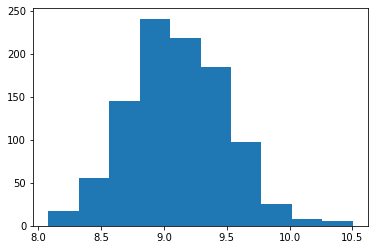

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(trace['beta'])

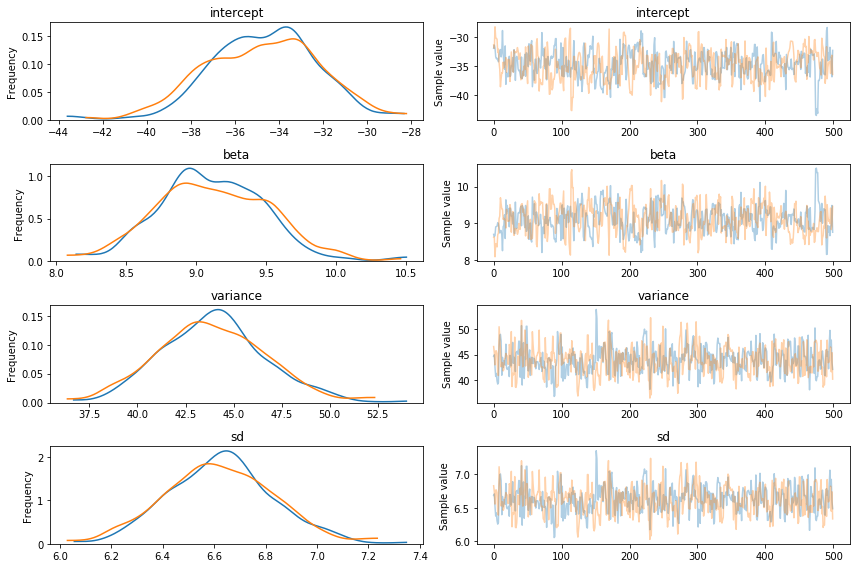

In [18]:
pm.traceplot(trace);

Remember that each of these samples corresponds to a different parameter setting. We can see visualize the resulting linear fits with the data:

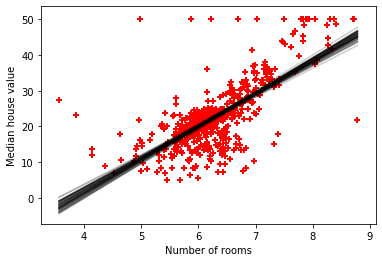

In [19]:
import numpy as np
n_samples = 500
x_range = np.linspace(df['RM'].min(),df['RM'].max())
for i in np.arange(n_samples,step=10):
    yhat = trace['intercept'][i] + trace['beta'][i] * x_range
    plt.plot(x_range,yhat,color='k',alpha = 0.2)
    plt.scatter(df['RM'],df['MEDV'],color='r',marker='+')
    plt.ylabel('Median house value')
    plt.xlabel('Number of rooms')

In case we are interested in hypothesis testing, we can easily get summaries of the High Posterior Density region (HPD). This is where most of the probability mass lies in the posterior. The PyMC3 default is to set it to the region in which 95% of the posterior samples reside. Another name for this region is a *credible interval*, the Bayesian analogue of a confidence interval.

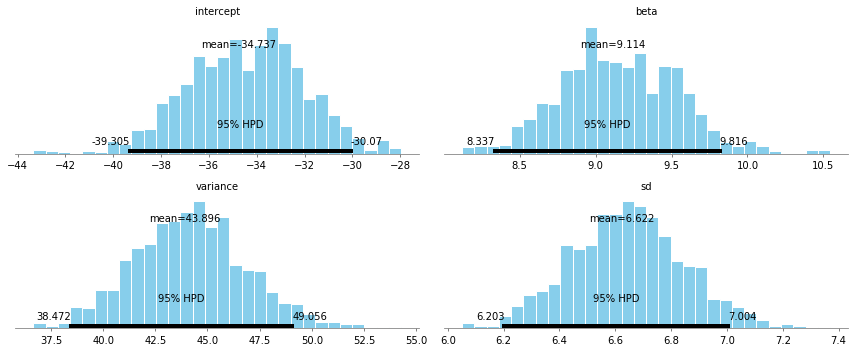

In [20]:
pm.plot_posterior(trace);

## In-class exercise

Modify the model from before to include a term proportional to the square of the number of rooms (i.e. `df['RM']**2`). Estimate the model parameters. What is the 95% HPD for that coefficient?

# Diagnosing poor samples

Just because we can write down a model in PyMC3 doesn't mean that we can always get good parameter estimates. If we accidentally write down a model that has some serious mathematical issues, then the samples can be misleading. Some cases in which this can happen are:
* The model has multiple modes in the posterior, some of which are not explored
* The posterior has a gradient of zero over some part of its parameter space
* If using an improper prior (doesn't integrate to 1), then the posterior may not be proper and sampler won't converge
* Model gradients are too sharp (technically speaking, the posterior curvature is too large) leading to numerical errors called *divergences*
* Some of the inputs or outputs are NaNs (non-numeric values)

Another way that our sampler can fail is by simply not reaching the true posterior distribution and sampling over most of the high probability values. For example, let's run a sampler for the same model as before but with only a few steps of the Metropolis algorithm

In [21]:
with simple_model:
    step = pm.Metropolis()
    short_trace = pm.sample(step=step,tune=100,draws=500,chains=4)

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [variance]
>Metropolis: [beta]
>Metropolis: [intercept]
Sampling 4 chains: 100%|██████████| 2400/2400 [00:00<00:00, 3738.79draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


The `tune` argument indicates the number of samples to be drawn and then discarded to warm-up the sampler before it reaches the posterior. `draws` indicates the actual number of samples returned in the trace object.

To look at each chain individually we have to select off a subset of the trace's values since it will normally lump all the chains together in the same array.

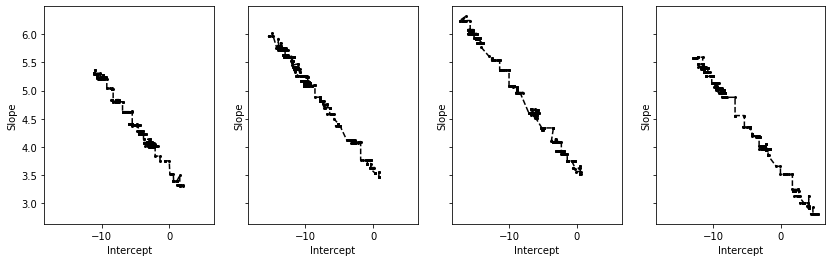

In [22]:
f,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize = (14,4))

for i in range(4):
    ax[i].plot(short_trace['intercept'][0+500*i:500+500*i],short_trace['beta'][0+500*i:500+500*i],
              marker='o',linestyle='--',color='k',markersize=2)
    ax[i].set_ylabel('Slope')
    ax[i].set_xlabel('Intercept')


The problem with this figure is that the chains all look a little different - they start in different locations and end up sampling different parts of the parameter space. Remember that we want our chains to be *ergodic* which means they all reach the posterior distribution regardless of our starting point.

If we run the sampler for much longer, we get more promising results:

In [23]:
with simple_model:
    step = pm.Metropolis()
    long_trace = pm.sample(step=step,tune=20000,draws=20000,chains=4)

Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>Metropolis: [variance]
>Metropolis: [beta]
>Metropolis: [intercept]
Sampling 4 chains: 100%|██████████| 160000/160000 [00:35<00:00, 4481.85draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


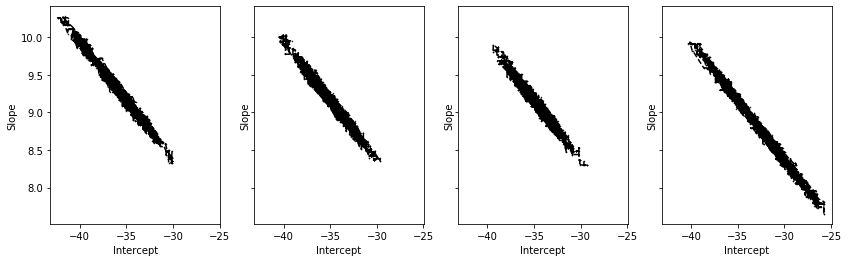

In [24]:
f,ax = plt.subplots(1,4,sharex=True,sharey=True,figsize = (14,4))

for i in range(4):
    ax[i].plot(long_trace['intercept'][0+5000*i:5000+5000*i],long_trace['beta'][0+5000*i:5000+5000*i],
              marker='o',linestyle='--',color='k',markersize=0.5,markerfacecolor='none')
    ax[i].set_ylabel('Slope')
    ax[i].set_xlabel('Intercept')


There are numerical metrics for assessing whether or not the chains have *mixed*, that is, whether they have reached the posterior distribution and are sampling from it. One of the most prominent is the Gelman-Rubin statistic $\hat{R}$ which is effectively a ratio of the between-chain variance of samples to the within-chain variance of samples. 

The intuition for using $\hat{R}$ is that if it is much larger than one, then the variation across the chains is much larger than their internal variability. A $\hat{R}$ close to 1 indicates that each individual chain is representative of the whole population of samples. Put differently, it means the chains all "look alike' so to speak and thus that they are mixing together.

This statistic tells us that the short trace samples are less reliable than those from the longer trace.

In [25]:
pm.summary(short_trace)['Rhat']

/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


intercept    1.121088
beta         1.123985
variance     1.016733
sd           1.017234
Name: Rhat, dtype: float64

In [26]:
pm.summary(long_trace)['Rhat']

intercept    1.024683
beta         1.024592
variance     1.000016
sd           1.000016
Name: Rhat, dtype: float64

# Multiple regression

We can very easily extend this model to include all 13 predictors. Before we do this, we'll standardize the data so that all the columns have zero mean and a variance of one.

In [27]:
df = (df-df.mean())/df.std()

In [28]:
predictors = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']

In [29]:
multiple_model = pm.Model()
with multiple_model:
    intercept = pm.Normal('intercept')
    beta      = pm.Normal('beta',shape=len(predictors))
    variance  = pm.InverseGamma('variance',alpha=0.1,beta=0.1)
    sd        = pm.Deterministic('sd',variance**0.5)
    
    yhat = intercept + pm.math.dot(df[predictors],beta)
    y    = pm.Normal('y',mu=yhat,sd=sd, observed=df['MEDV'])
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [variance, beta, intercept]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 673.28draws/s]


With lots of parameters, it can be hard to tell which ones are important. `forestplot` can be used to help figure this out. Each of the horizontal lines is a different chain and the dot is the posterior mean for that chain. This plot shows the high probability regions under the posterior for each coefficient.

/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/home/ckrapu/anaconda3/envs/pymc3/lib/python3.6/site-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


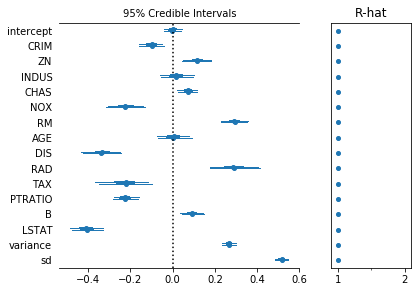

In [30]:
pm.forestplot(trace,ylabels=['intercept'] + predictors + ['variance','sd']);

## In-class exercise
* Which variables appear to be least important in this model?
* Do the chains appear to be well-mixed?
* Which variables have the strongest positive correlation with the median house value?
* Modify the model above to include all 2nd order interactions between variables, i.e. number_of_rooms * age in the statistical model
* Identify which, if any, interactions appear to be statistically significant